In [1]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

from pathlib import Path

2024-01-15 10:05:10.867848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
data = pd.read_csv(Path.cwd() / '..' / 'data' / '22_12_29_ga.csv')
usedf = data.drop(["Generation"], axis=1)
# Now add errors to the data
errors = pickle.load(open(Path.cwd() / '..' / 'data' / 'df_errors.pkl', 'rb'))
minus_err = errors["Minus_Errs"].values
plus_err = errors["Plus_Errs"].values
print(usedf.head())
X = usedf.drop(['Fitness'], axis=1).values
y = usedf['Fitness'].values
print(X.shape, y.shape)

   InnerRadius    Length  Quadratic    Linear  InnerRadius2  Length2  \
0     2.785070   44.1456  -0.008193  0.306436       3.20903  37.9422   
1     6.646530   65.2695   0.001421 -0.119595       2.04081  51.5247   
2     6.249200   42.8384   0.002491 -0.140030       3.77085  38.4759   
3     7.290460   66.8939   0.004028 -0.300474       3.74365  45.2208   
4     0.414064  125.7330  -0.000943  0.146930       6.13380  66.8088   

   Quadratic2   Linear2  Fitness  
0    0.001423 -0.078648  5.20443  
1   -0.002964  0.179673  5.28597  
2   -0.000356  0.024653  5.11788  
3    0.004745 -0.249696  5.15964  
4    0.003556 -0.230589  4.61805  
(3100, 8) (3100,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train_minus_errs, x_test_minus_errs, x_train_plus_errs, x_test_plus_errs= train_test_split(minus_err, plus_err, test_size=0.20, random_state=42)

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_mse", patience=3)]

regressor = baseline_model()

regressor.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = regressor.fit(X_train, y_train, epochs=250, batch_size=16, 
                        validation_data=(X_test, y_test), callbacks=callbacks)

y_pred = regressor.predict(X_test)

mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

print(mse)

2024-01-15 10:05:25.497394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/250
155/155 [==============================] - 1s 2ms/step - loss: 8.7181 - mse: 8.7181 - val_loss: 0.6241 - val_mse: 0.6241
Epoch 2/250
155/155 [==============================] - 0s 1ms/step - loss: 0.3947 - mse: 0.3947 - val_loss: 0.2557 - val_mse: 0.2557
Epoch 3/250
155/155 [==============================] - 0s 1ms/step - loss: 0.1668 - mse: 0.1668 - val_loss: 0.1373 - val_mse: 0.1373
Epoch 4/250
155/155 [==============================] - 0s 1ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.1021 - val_mse: 0.1021
Epoch 5/250
155/155 [==============================] - 0s 1ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 0.0716 - val_mse: 0.0716
Epoch 6/250
155/155 [==============================] - 0s 1ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0464 - val_mse: 0.0464
Epoch 7/250
155/155 [==============================] - 0s 1ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0424 - val_mse: 0.0424
Epoch 8/250
155/155 [==============================] - 0s 1ms/step - 

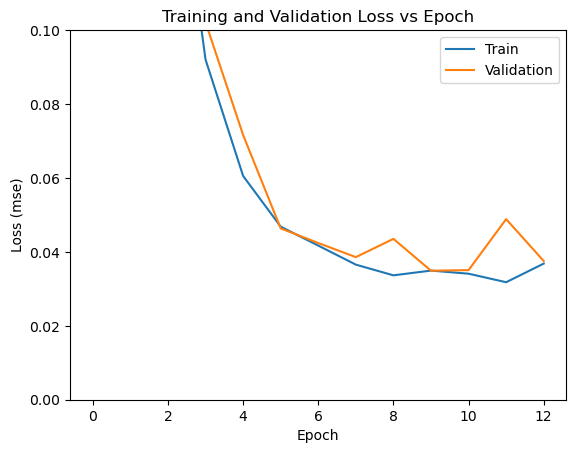

In [4]:

# print the training loss, validation loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 0.1)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.title('Training and Validation Loss vs Epoch')
plt.show()


Mean squared error: 0.03752


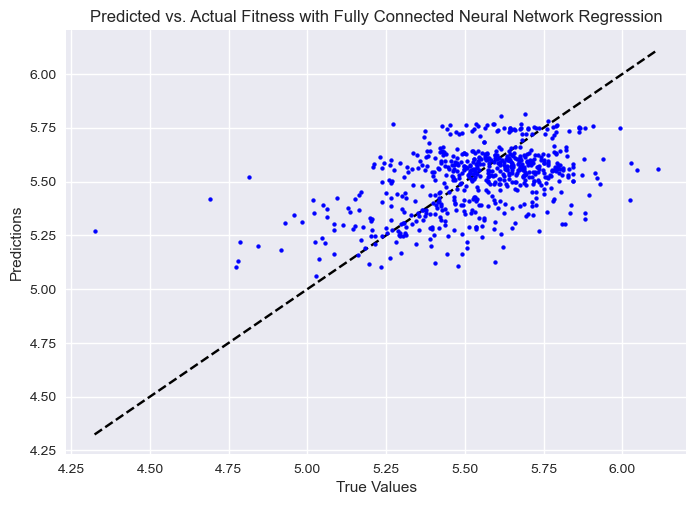

In [5]:
#print the mean squared error
print("Mean squared error: %.5f" % mse)
# set style to seaborn
plt.style.use('seaborn')
plt.scatter(y_test, y_pred, s=30, c='b', marker='.', zorder=10)
minfit = np.min(y_test)
maxfit = np.max(y_test)
plt.plot([minfit, maxfit], [minfit, maxfit], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. Actual Fitness with Fully Connected Neural Network Regression')
plt.show()

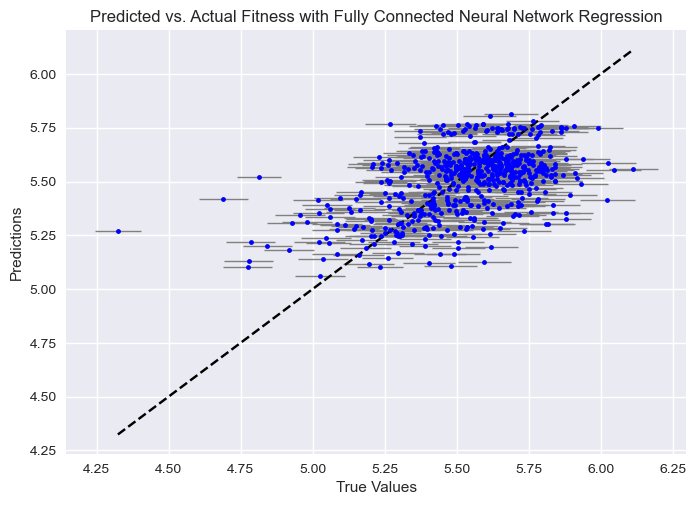

In [6]:
# set style to seaborn
plt.style.use('seaborn')
plt.errorbar(y_test, y_pred, xerr=[x_test_minus_errs, x_test_plus_errs], fmt='.', color='b',
                ecolor='gray', elinewidth=1, capsize=0.8)
minfit = np.min(y_test)
maxfit = np.max(y_test)
plt.plot([minfit, maxfit], [minfit, maxfit], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predicted vs. Actual Fitness with Fully Connected Neural Network Regression')
plt.show()

In [7]:
# calculate the percentage of the predicted data that is within the error bars
total_in = 0
for i in range(len(y_test)):
    if y_test[i] - x_test_minus_errs[i] <= y_pred[i] <= y_test[i] + x_test_plus_errs[i]:
        total_in += 1
print("Percentage of predicted data within error bars: %.2f" % (total_in / len(y_test) * 100))

Percentage of predicted data within error bars: 38.39


In [9]:
max_array = np.max([x_test_minus_errs, x_test_plus_errs], axis=0)
mean_err = np.mean(max_array)
diff_array = [y_test[i] - y_pred[i] for i in range(len(y_test))]

Text(0.5, 1.0, 'Prediction Difference vs Arasim StDev')

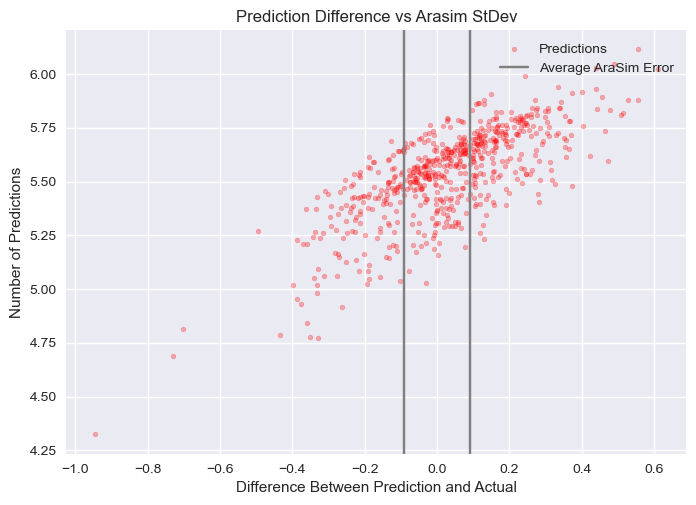

In [14]:
plt.scatter(diff_array, y_test, color='red', alpha=0.3, marker='.', label="Predictions")
plt.axvline(x=mean_err, color="grey", label="Average AraSim Error")
plt.axvline(x=mean_err*-1, color="grey")#, label="Average AraSim Error")
plt.ylabel("Number of Predictions")
plt.xlabel("Difference Between Prediction and Actual")
plt.legend(loc="upper right")
plt.title("Prediction Difference vs Arasim StDev")

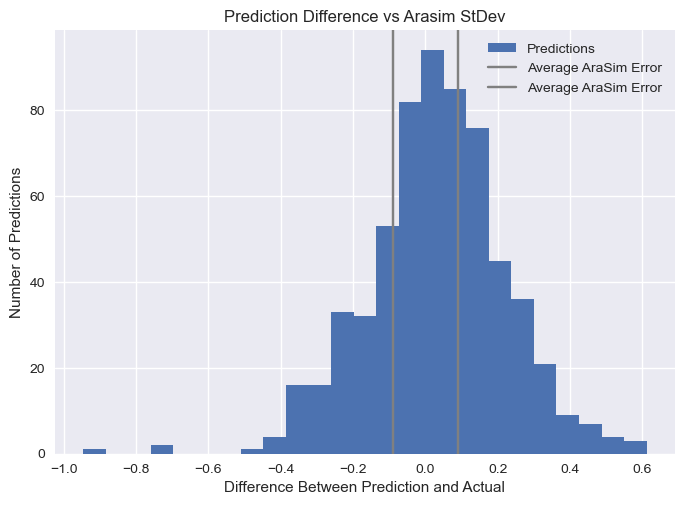

In [15]:
new_arr = [float(diff_array[i]) for i in range(len(diff_array))]
plt.hist(new_arr, bins=25, label="Predictions")
plt.axvline(x=mean_err, color="grey", label="Average AraSim Error")
plt.axvline(x=mean_err*-1, color="grey", label="Average AraSim Error")
plt.ylabel("Number of Predictions")
plt.xlabel("Difference Between Prediction and Actual")
plt.legend(loc="upper right")
plt.title("Prediction Difference vs Arasim StDev")
plt.show()


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train_minus_errs, x_test_minus_errs, x_train_plus_errs, x_test_plus_errs= train_test_split(minus_err, plus_err, test_size=0.20, random_state=42)
mse_list = []
perc_in_errs = []
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(8,)))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

X_test = scaler.transform(X_test)

for i in range(1, 2401, 100):
    print(i)
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_mse", patience=3),
                keras.callbacks.ModelCheckpoint(filepath=f"tempmodel{i}.h5", save_best_only=True, monitor="val_mse")]
    X_train_use = X_train[:i]
    y_train_use = y_train[:i]
    

    # scale the data
    scaler = StandardScaler()
    X_train_use = scaler.fit_transform(X_train_use)

    regressor = baseline_model()

    regressor.compile(optimizer='adam', loss='mse', metrics=['mse'])

    history = regressor.fit(X_train_use, y_train_use, epochs=250, batch_size=16, 
                            validation_data=(X_test, y_test), callbacks=callbacks)

    tempmodel = keras.models.load_model(f"tempmodel{i}.h5")
    
    y_pred = tempmodel.predict(X_test)

    mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
    total_in = 0
    for i in range(len(y_test)):
        if y_test[i] - x_test_minus_errs[i] <= y_pred[i] <= y_test[i] + x_test_plus_errs[i]:
            total_in += 1
    mse_list.append(mse)
    perc_in_errs.append(total_in / len(y_test) * 100)


1
Epoch 1/250
1/1 [==============================] - 0s 487ms/step - loss: 31.1411 - mse: 31.1411 - val_loss: 30.6856 - val_mse: 30.6856
Epoch 2/250
1/1 [==============================] - 0s 65ms/step - loss: 31.1299 - mse: 31.1299 - val_loss: 30.6745 - val_mse: 30.6745
Epoch 3/250
1/1 [==============================] - 0s 68ms/step - loss: 31.1188 - mse: 31.1188 - val_loss: 30.6635 - val_mse: 30.6635
Epoch 4/250
1/1 [==============================] - 0s 74ms/step - loss: 31.1076 - mse: 31.1076 - val_loss: 30.6524 - val_mse: 30.6524
Epoch 5/250
1/1 [==============================] - 0s 73ms/step - loss: 31.0965 - mse: 31.0965 - val_loss: 30.6413 - val_mse: 30.6413
Epoch 6/250
1/1 [==============================] - 0s 69ms/step - loss: 31.0853 - mse: 31.0853 - val_loss: 30.6303 - val_mse: 30.6303
Epoch 7/250
1/1 [==============================] - 0s 69ms/step - loss: 31.0742 - mse: 31.0742 - val_loss: 30.6192 - val_mse: 30.6192
Epoch 8/250
1/1 [==============================] - 0s 64ms/

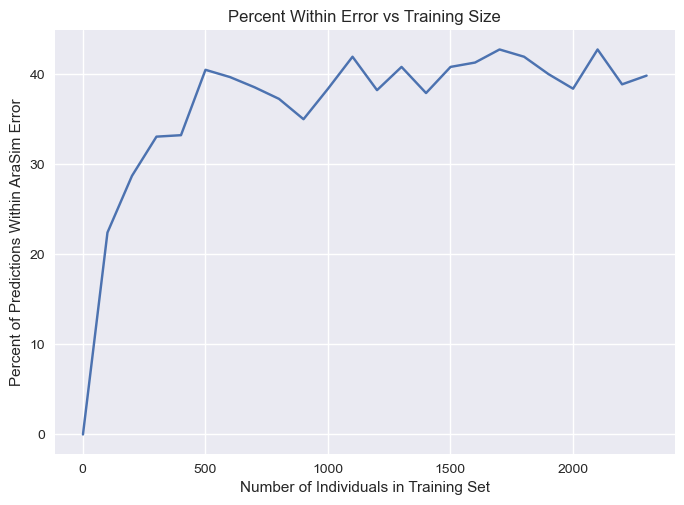

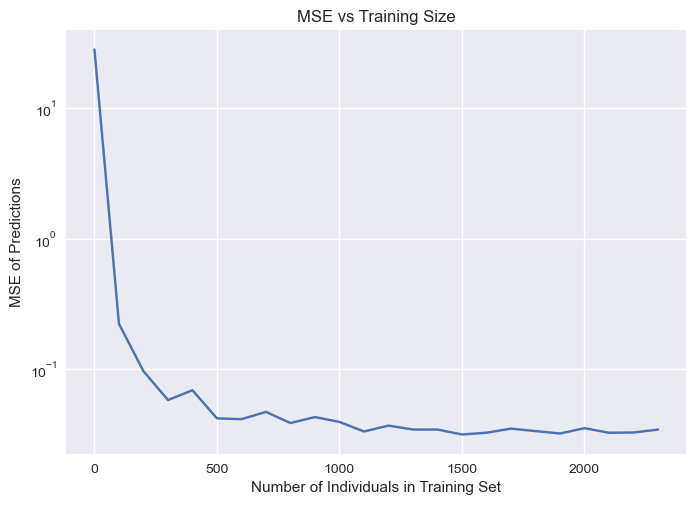

In [13]:
xticks = [i for i in list(range(1, 2401, 100))]
plt.plot(xticks, perc_in_errs, label="Percent of Preds within Error")
plt.xlabel("Number of Individuals in Training Set")
plt.ylabel("Percent of Predictions Within AraSim Error")
plt.title("Percent Within Error vs Training Size")
plt.show()
plt.plot(range(1, 2401, 100), mse_list)
plt.xlabel("Number of Individuals in Training Set")
plt.ylabel("MSE of Predictions")
plt.title("MSE vs Training Size")
plt.yscale("log")
plt.show()